Imports

In [4]:
# Library imports

from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets

ModuleNotFoundError: No module named 'torch'

MNIST Dataset Loader

In [76]:
# MNIST Dataset Loader and Visualization

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Extract data and labels
x, y = mnist['data'], mnist['target']
y = y.astype(int)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)


Convolutional Neural Network (CNN)

In [77]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layer 1: 1 input channel (grayscale), 32 output channels (filters), 3x3 kernel size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Convolutional layer 2: 32 input channels, 64 output channels, 3x3 kernel size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Max-pooling layer: 2x2 pooling size
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layer 1 (flattened): 64 channels * 7 * 7 (after two pooling operations)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Fully connected output layer (10 classes for digit classification)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply conv1, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply conv2, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the tensor before passing it to the fully connected layers
        x = x.view(-1, 64 * 7 * 7)

        # Apply fully connected layer 1 and ReLU activation
        x = F.relu(self.fc1(x))

        # Output layer (no activation here, we'll apply softmax during evaluation)
        x = self.fc2(x)
        return x


In [78]:
# Define data augmentation for the training dataset
transform_train = transforms.Compose([
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random affine transformation (translation)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image (same as before)
])

# Define the transform for the test dataset (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image (same as before)
])

# Load the MNIST training dataset with data augmentation
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)  # Loading with augmentation

# Load the MNIST test dataset without augmentation
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)  # Loading without augmentation

In [79]:
# Instantiate the CNN model
model = SimpleCNN()  # Create an instance of the CNN class

# Loss function and optimizer for CNN (same as FCNN)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent (you can also try Adam)

# Set up the DataLoader for training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Training loop for the CNN model
epochs = 5
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

     # Iterate over batches of data
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 1, 28, 28)  # Ensure the correct shape
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Pass the inputs through the CNN model
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the model parameters
        running_loss += loss.item()  # Accumulate the loss for logging

    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 1.2297
Epoch [2/5], Loss: 0.3483
Epoch [3/5], Loss: 0.2205
Epoch [4/5], Loss: 0.1692
Epoch [5/5], Loss: 0.1387


In [80]:
# Set up the DataLoader for testing
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

# Evaluate the CNN model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:
        outputs = model(inputs)  # Pass the inputs through the CNN model
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        total += labels.size(0)  # Increment total samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.93%


In [81]:
# Save the model
torch.save(model.state_dict(), "cnn_model.pth")  # Save the model parameters
print("Model saved as cnn_model.pth")

Model saved as cnn_model.pth


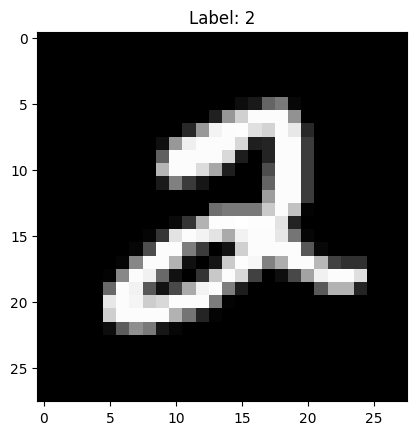

In [82]:
# Load the MNIST dataset
mnist = datasets.MNIST(root='./data', train=True, download=True)

# Get a random image and its label
image, label = mnist[5]  # Change the index to get different images

# Display the image directly
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

# Save the image as a PNG file
image.save('mnist_sample.png')